 ##  Nursery Database was derived from a hierarchical decision model originally developed to rank applications for nursery schools. It was used during several years in 1980's when there was excessive enrollment to these schools in Ljubljana, Slovenia, and the  rejected applications frequently needed an objective explanation.

In [1]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler
from numpy import array
import warnings
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data_df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data",header=None)

In [3]:
data_df.columns=["parents",'has_nurs', 'form', 'children', 'housing', 'finance','social','health','Eval']

In [4]:
data_df.head(4)

,parents,has_nurs,form,children,housing,finance,social,health,Eval
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend


In [5]:
data_df.columns

Index(['parents', 'has_nurs', 'form', 'children', 'housing', 'finance',
       'social', 'health', 'Eval'],
      dtype='object')

# Dataset has eight predictors along with Target: 
    #parents     Parent's occupation (usual, pretentious, great_pret)
    #has_nurs    Child's nursery (proper, less_proper, improper, critical, very_crit)
    #form        Form of the family (complete, completed, incomplete, foster)
    #children    Number of children (1, 2, 3, more)
    #housing     Housing condition (convenient, less_conv, critical)
    #finance     Financial standing of the family (convenient, inconv)
    #social      Social conditions (non-prob, slightly_prob, problematic)
    #health      Health conditions (recommended, priority, not_recom)
           
    # Eval        Evaluation of applications for nursery schools(not_recom, recommend,very_recom, priority, spec_prior)

## Panda Dataframe is converted to Pyspark Database as we want to implement in pyspark

In [6]:
spark =pyspark.sql.SparkSession.builder.master("local").getOrCreate()

In [7]:
df_data=spark.createDataFrame(data_df)

In [8]:
df_data.printSchema()

root
 |-- parents: string (nullable = true)
 |-- has_nurs: string (nullable = true)
 |-- form: string (nullable = true)
 |-- children: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- finance: string (nullable = true)
 |-- social: string (nullable = true)
 |-- health: string (nullable = true)
 |-- Eval: string (nullable = true)



## categorical predictor columns and use of StringIndexer

In [9]:
cat_cols=["parents",'has_nurs', 'form', 'children', 'housing', 'finance','social','health']

In [10]:
indexer=[StringIndexer(inputCol=cat_col,outputCol=cat_col+'index',handleInvalid='keep').fit(df_data) for cat_col in cat_cols]

## categorical target column and use of StringIndexer and IndexToString

In [11]:
eval_indexer = StringIndexer(inputCol='Eval',outputCol='EvalIndex',handleInvalid='keep').fit(df_data)

In [12]:
indexer_to_eval = IndexToString(inputCol='prediction',outputCol='Evaluted_Class',labels=eval_indexer.labels)

## VectorAssembler and Pipeline and CrossValidator

In [13]:
feature_set=[cat_col+'index' for cat_col in cat_cols]

In [14]:
assembler=VectorAssembler(inputCols=feature_set,outputCol='features')

In [15]:
random_forest_dt =RandomForestClassifier(featuresCol='features',labelCol='EvalIndex',maxBins=1500,numTrees=32,seed=42)

In [16]:
random_forest_pipeline = Pipeline(stages=indexer+[assembler,eval_indexer,random_forest_dt,indexer_to_eval])

In [17]:
random_forest_paramGrid = ParamGridBuilder()\
                          .addGrid(random_forest_dt.numTrees, [25,30])\
                          .addGrid(random_forest_dt.maxDepth, [10,15,20])\
                          .build()

In [18]:
evaluator_random_forest = MulticlassClassificationEvaluator(
    labelCol="EvalIndex", predictionCol="prediction", metricName="accuracy")

In [19]:
crossval = CrossValidator(estimator=random_forest_pipeline,
                          estimatorParamMaps=random_forest_paramGrid,
                          evaluator= evaluator_random_forest,
                          numFolds=2)

## Splitting Data and Train and Test Data and Model Fitting

In [20]:
train_data, test_data = df_data.randomSplit([0.7,.3],seed=23)

In [21]:
cvModel=crossval.fit(train_data)

In [22]:
random_forest_fit_model = cvModel.bestModel

In [23]:
predictions_random_forest = random_forest_fit_model.transform(test_data)

In [24]:
accuracy_random_forest = evaluator_random_forest.evaluate(predictions_random_forest)

In [25]:
print("Test Error = %g " % (1.0 - accuracy_random_forest))

Test Error = 0.00775194 


In [26]:
predictionAndLabel = predictions_random_forest.select("prediction", "EvalIndex").rdd

## Confusin Matrix for MultiClass classification 

In [27]:
metrics = MulticlassMetrics(predictionAndLabel)

In [28]:
print("Precision = %s" % metrics.precision()); print("Recall = %s" % metrics.recall());print("F1 Score = %s" % metrics.fMeasure())

Precision = 0.9922480620155039
Recall = 0.9922480620155039
F1 Score = 0.9922480620155039


#Explantion why precision, recall and F1 score can have same value:

Definitions of precision, recall and F1 score:
    
True positive samples (TP) are samples that were classified positive and are really positive. 
False positive samples (FP) are samples that were classified positivebut should have been 
classified negative. Analogously, false negative samples (FN) were classified negative
but should be positive. Here, TP, FP and FN stand for the respective number of samples 
in each of the classes.

Precision P=TP/(TP+FP)
Precision can be intuitively understood as the classifier’s ability to only predict
really positive samples as positive. For example, a classifier that classifies just
everything as positive would have a precision of 0.5 in a balanced test set
(50% positive, 50% negative). One that has no false positives, i.e. classifies only
the true positives as positive would have a precision of 1.0. So basically, the less
false positives a classifier gives, the higher is its precision.

Recall R=TP/(TP+FN)
Recall can be interpreted as the amount of positive test samples that were actually 
classified as positive. A classifier that just outputs positive for every sample,
regardless if it is really positive, would get a recall of 1.0 but a lower precision. 
The less false negatives a clasifier gives, the higher is its recall.

So the higher precision and recall are, the better the classifier performs because
it detects most of the positive samples (high recall) and does not detect many samples 
that should not be detected (high precision). In order to quantify that, 
we can use another metric called F1 score.

F1 score F1=2P∗R/(P+R)
This is just the weighted average between precision and recall. The higher precision and 
recall are, the higher the F1 score is. We can directly see from this formula, that 
if P=R, then F1=P=R, because:

F1=2P∗R/(P+R)=2P∗P/(P+P)=P
So this already explains why the F1 score is the same as precision and recall, if precision
and recall are the same

In [29]:
confusion_mat=metrics.confusionMatrix()

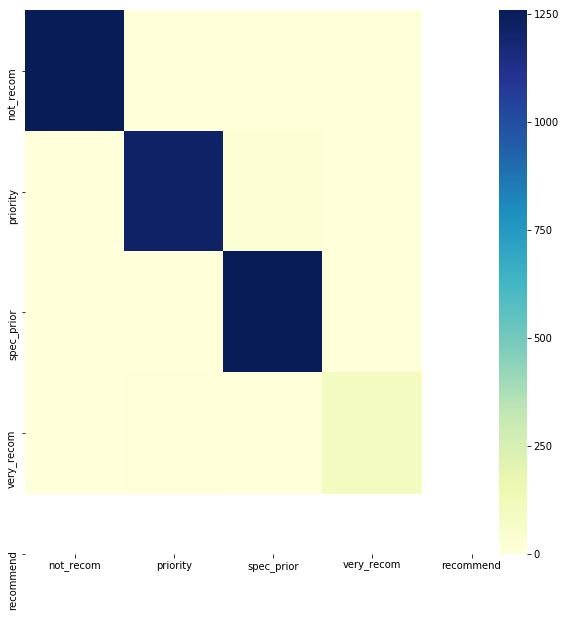

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_mat.toArray(),xticklabels=indexer_to_eval.getLabels(),yticklabels=indexer_to_eval.getLabels(),cmap="YlGnBu")
plt.show()

In [31]:
confusion_mat_norm=confusion_mat.toArray()/np.expand_dims(confusion_mat.toArray().sum(axis=1),axis=1)

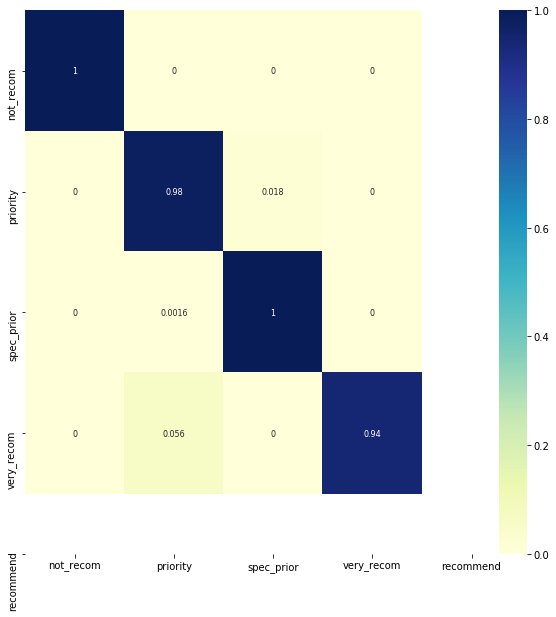

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_mat_norm,xticklabels=indexer_to_eval.getLabels(),yticklabels=indexer_to_eval.getLabels(),cmap="YlGnBu",annot=True,annot_kws={"size": 8})
plt.show()